#  News Sentiment Analyzer for Stock Market Prediction



# Step 1 — Install required libraries
Install all core dependencies: Hugging Face Transformers, Datasets, Pandas, Numpy, TQDM for progress bars,  
and XGBoost for classification.


In [1]:
!pip install transformers xgboost pandas numpy tqdm matplotlib datasets --quiet


# Step 2 — Import necessary libraries
These imports cover everything needed for data handling, model loading, embedding extraction, and training.


In [46]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
tqdm.pandas()


In [57]:
login()


# Step 3 — Load dataset
`mltrev23/financial-sentiment-analysis` dataset from Hugging Face  
and keep a small subset for faster demonstration.


In [52]:
# Step 1: Load dataset and prepare columns
dataset = load_dataset("mltrev23/financial-sentiment-analysis", split="train[:500]")
df = pd.DataFrame(dataset)

# Rename columns for consistency
df = df.rename(columns={"Sentence": "all_news", "Sentiment": "Sentiment"})

# Drop missing values and reset index
df = df.dropna(subset=["all_news", "Sentiment"]).reset_index(drop=True)

print(" Data ready! Shape:", df.shape)
df["Sentiment"].value_counts()
df.head()


Repo card metadata block was not found. Setting CardData to empty.


 Data ready! Shape: (500, 2)


,all_news,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# Step 5 — Generate FinBERT embeddings
 `ProsusAI/finbert` model is used to create dense vector embeddings for each news headline.  
These embeddings represent the meaning of the text numerically.


In [53]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

df["embedding"] = df["all_news"].progress_apply(get_embedding)
print("Embeddings generated successfully!")


Using device: cpu


100%|██████████| 500/500 [01:52<00:00,  4.46it/s]

Embeddings generated successfully!


# Step 6 — Encode sentiment labels and split data
Convert textual sentiment labels to numeric values, then create training and test splits.


In [54]:
le = LabelEncoder()
df["Sentiment_encoded"] = le.fit_transform(df["Sentiment"])

X = np.vstack(df["embedding"].values)
y = df["Sentiment_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training samples:", X_train.shape[0], "| Test samples:", X_test.shape[0])


Training samples: 400 | Test samples: 100


# Step 7 — Train XGBoost model
For training -  XGBoost classifier using FinBERT embeddings as input features to predict sentiment labels.


In [60]:
model_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss"
)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)




## Step 8 — Model Predictions with Sentiment Scores

After training the XGBoost classifier, we inspect how the model performs on unseen financial headlines.  
This step displays a few random samples along with their true sentiment labels and model predictions.  
It helps in verifying that the model captures contextual meaning correctly.


In [62]:
# Inspect Model Predictions with Sentiment Scores
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
# Randomly select a few test samples
num_samples = min(5, len(X_test))
sample_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

print("\nSample Model Predictions:\n")
for i in sample_indices:
    # Try to find the corresponding text by index from df_test if you kept it,
    # else this part uses a placeholder
    text = df.iloc[i]["all_news"] if i < len(df) else "(headline unavailable)"
    true_label = le.inverse_transform([y_test[i]])[0]
    pred_label = le.inverse_transform([y_pred[i]])[0]
    print(f"News: {text}")
    print(f"True Sentiment: {true_label} | Predicted: {pred_label}")
    print("-" * 80)



Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

    negative       0.54      0.44      0.48        16
     neutral       0.79      0.84      0.81        55
    positive       0.79      0.79      0.79        29

    accuracy                           0.76       100
   macro avg       0.71      0.69      0.70       100
weighted avg       0.75      0.76      0.76       100


Sample Model Predictions:

News: The Stockmann department store will have a total floor space of over 8,000 square metres and Stockmann 's investment in the project will have a price tag of about EUR 12 million .
True Sentiment: neutral | Predicted: positive
--------------------------------------------------------------------------------
News: Stora Enso has also had meetings with the labor authorities , Employment and Economic Development Centres and representatives of the government in order to find solutions .
True Sentiment: negative | Predicted: neutral
-------------

## Step 9 — Visualizing Model Performance

This section presents a visual summary of the model’s accuracy and class-wise performance.  
We use a **confusion matrix** to show how often each sentiment class (positive, neutral, negative)  
was correctly or incorrectly classified.  
A bar plot also illustrates the overall model accuracy.


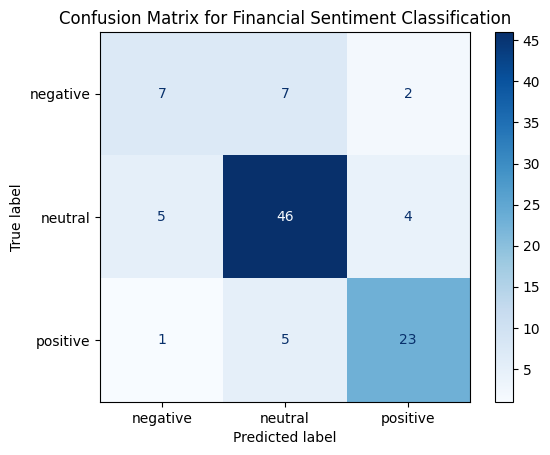

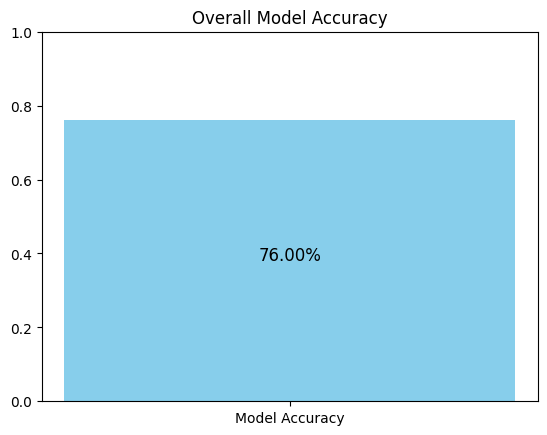

In [63]:
# Step 8 — Plot Confusion Matrix and Accuracy Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Financial Sentiment Classification")
plt.show()

# Accuracy visualization
acc = accuracy_score(y_test, y_pred)
plt.bar(["Model Accuracy"], [acc], color="skyblue")
plt.ylim(0, 1)
plt.text(0, acc / 2, f"{acc * 100:.2f}%", ha='center', fontsize=12, color="black")
plt.title("Overall Model Accuracy")
plt.show()


## Step 10 — Interactive Headline Sentiment Prediction

To make the project more practical, this section adds an interactive prediction interface.  
Users can type any financial headline, and the model will instantly return its predicted sentiment.  
This simulates a real-world financial news sentiment analyzer.


In [65]:
# Step 9 — Interactive Prediction Box with Sentiment Score

from IPython.display import display
import ipywidgets as widgets
import numpy as np

def predict_headline_sentiment(text):
    # Convert text into embedding
    emb = get_embedding(text)
    probs = model_xgb.predict_proba(emb.reshape(1, -1))[0]
    pred = np.argmax(probs)

    # Decode label + confidence
    sentiment = le.inverse_transform([pred])[0]
    confidence = np.max(probs)

    print(f"\nHeadline: {text}")
    print(f"Predicted Sentiment: {sentiment} ({confidence:.2f} confidence)")

    return sentiment, confidence

# Text input box
text_box = widgets.Text(
    value="RBI announces rate cut to boost economy",
    placeholder="Enter a financial news headline...",
    description="Headline:",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')
)

# Predict button
button = widgets.Button(description="Predict Sentiment", button_style="info")

def on_button_clicked(b):
    predict_headline_sentiment(text_box.value)

button.on_click(on_button_clicked)

display(text_box, button)


Text(value='RBI announces rate cut to boost economy', description='Headline:', layout=Layout(width='100%'), pl…

Button(button_style='info', description='Predict Sentiment', style=ButtonStyle())


Headline: Infosys reports higher quarterly profits
Predicted Sentiment: positive (0.98 confidence)
